In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re


# 1. Загрузка и очистка данных 

In [3]:
data = pd.read_csv("dataset_jug.csv")

print(data.shape)
data.head()

(76, 10)


,title,speaker,hall,companies,date,start_time,end_time,category,conf,text
0,State of Mobile Dev 2025 Autumn от Программног...,"Андрей Дмитриев, Юрий Дубовой, Кирилл Клебанов\n",1,"JUG Ru Group, Делимобиль",18-11-2025,10:00,10:45,NaN,Mobius,"Весной мы запустили TechRadar, чтобы изучить р..."
1,Волновая архитектура на практике,Юрий Дубовой,1,Делимобиль,18-11-2025,10:55,11:40,Architecture,Mobius,"В прошлом сезоне мы увидели Дракона сложности,..."
2,AntiSOLID,Данил Перевалов,1,Циан,18-11-2025,12:00,12:45,Architecture,Mobius,Все с пеленок знают о принципах SOLID. Они дол...
3,kotlinx.fuzz: Why Fuzz Testing Matters,Александр Соколинский,1,Coffee&Code,18-11-2025,13:15,14:00,Architecture,Mobius,"Обсудим, что такое Fuzz Testing, какие баги с ..."
4,Новая эра мобильной разработки: запускаем LLM ...,Самир Ахмедов,1,Surf,18-11-2025,14:30,15:15,Trends,Mobius,Мы живем в абсолютно удивительной новой эре бо...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       76 non-null     object
 1   speaker     76 non-null     object
 2   hall        76 non-null     int64 
 3   companies   76 non-null     object
 4   date        76 non-null     object
 5   start_time  76 non-null     object
 6   end_time    76 non-null     object
 7   category    70 non-null     object
 8   conf        76 non-null     object
 9   text        76 non-null     object
dtypes: int64(1), object(9)
memory usage: 6.1+ KB


In [5]:
data[data['category'].isna()]

,title,speaker,hall,companies,date,start_time,end_time,category,conf,text
0,State of Mobile Dev 2025 Autumn от Программног...,"Андрей Дмитриев, Юрий Дубовой, Кирилл Клебанов\n",1,"JUG Ru Group, Делимобиль",18-11-2025,10:00,10:45,NaN,Mobius,"Весной мы запустили TechRadar, чтобы изучить р..."
39,Закрытие конференции Mobius 2025 Autumn,"Юрий Дубовой, Кирилл Клебанов\n",1,Делимобиль\n,19-11-2025,18:50,19:05,NaN,Mobius,"Подводим итоги, вспоминаем яркие моменты и рас..."
40,State of Testing 2025 от Программного комитета...,"Юлия Атлыгина, Андрей Дмитриев",1,"Tempo\r, JUG Ru Group",19-11-2025,10:30,11:15,NaN,Heisenbug,Развитие технологических решений не всегда про...
56,Как разрабатываются и тестируются новые лекарства,"Александр Надолинский, Мария Кондаурова\r",1,BIOCAD,19-11-2025,18:00,18:45,NaN,Heisenbug,Разработка нового препарата — это длинный и до...
74,"Матерюсь — значит, существую","Юлия Афонина, Андрей Дмитриев",1,JUG Ru Group,20-11-2025,18:00,18:45,NaN,Heisenbug,Ругательства давно стали частью человеческой р...
75,Закрытие конференции Heisenbug 2025 Autumn,"Авенир Воронов, Софья Селезнева\r",1,"Explyt, Гранч",20-11-2025,18:50,19:00,NaN,Heisenbug,"Подводим итоги, вспоминаем яркие моменты и рас..."


In [6]:
data['category'].value_counts()

Under the Hood                 13
Trends                          7
UX/UI in Mobile Development     6
Architecture                    5
Tools/Frameworks                5
Automation                      5
Infrastructure                  4
AI                              4
Mobile                          4
Security                        3
Best Practices                  3
Product Quality                 3
Load Testing                    2
Hardware                        2
GameDev                         1
Biohacking                      1
General                         1
Automation`                     1
Name: category, dtype: int64

In [7]:
# Заполним пропущенные категории в ручную, отталкиваясь от смысла докладов

data.loc[0, 'category'] = "Interesting things"
data.loc[39, 'category'] = "General"
data.loc[40, 'category'] = "Interesting things"
data.loc[56, 'category'] = "Interesting things"
data.loc[74, 'category'] = "General"
data.loc[75, 'category'] = "Interesting things"

In [8]:
data.isna().sum()

title         0
speaker       0
hall          0
companies     0
date          0
start_time    0
end_time      0
category      0
conf          0
text          0
dtype: int64

In [9]:
df = data.copy()
df_new = data.copy()


# 2. Анализ данных

In [11]:
df.columns

Index(['title', 'speaker', 'hall', 'companies', 'date', 'start_time',
       'end_time', 'category', 'conf', 'text'],
      dtype='object')

| Название признака | Описание |
| ---: | :--- |
| title | название доклада |
| speaker | спикер |
| hall | номер зала |
| companies | компания |
| date | дата |
| start_time | начальное время доклада |
| end_time | конченое время доклада |
| category | категория |
| conf | название конференции |
| text | краткое описание доклада |

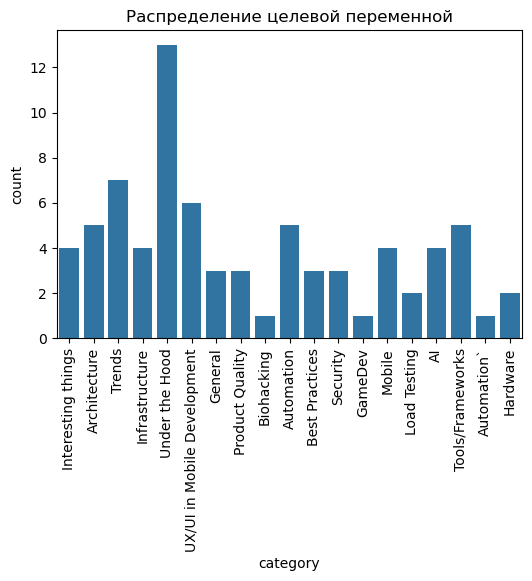

In [13]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='category')
plt.title('Распределение целевой переменной')
plt.xticks(rotation=90)
plt.show()

In [14]:
cat_columns = df.select_dtypes(include='object')
cat_columns.head()

,title,speaker,companies,date,start_time,end_time,category,conf,text
0,State of Mobile Dev 2025 Autumn от Программног...,"Андрей Дмитриев, Юрий Дубовой, Кирилл Клебанов\n","JUG Ru Group, Делимобиль",18-11-2025,10:00,10:45,Interesting things,Mobius,"Весной мы запустили TechRadar, чтобы изучить р..."
1,Волновая архитектура на практике,Юрий Дубовой,Делимобиль,18-11-2025,10:55,11:40,Architecture,Mobius,"В прошлом сезоне мы увидели Дракона сложности,..."
2,AntiSOLID,Данил Перевалов,Циан,18-11-2025,12:00,12:45,Architecture,Mobius,Все с пеленок знают о принципах SOLID. Они дол...
3,kotlinx.fuzz: Why Fuzz Testing Matters,Александр Соколинский,Coffee&Code,18-11-2025,13:15,14:00,Architecture,Mobius,"Обсудим, что такое Fuzz Testing, какие баги с ..."
4,Новая эра мобильной разработки: запускаем LLM ...,Самир Ахмедов,Surf,18-11-2025,14:30,15:15,Trends,Mobius,Мы живем в абсолютно удивительной новой эре бо...


In [15]:
cat_columns.describe()

,title,speaker,companies,date,start_time,end_time,category,conf,text
count,76,76,76,76,76,76,76,76,76
unique,76,76,59,3,16,16,19,2,76
top,State of Mobile Dev 2025 Autumn от Программног...,"Андрей Дмитриев, Юрий Дубовой, Кирилл Клебанов\n",Сбер,19-11-2025,11:45,12:30,Under the Hood,Mobius,"Весной мы запустили TechRadar, чтобы изучить р..."
freq,1,1,6,38,9,9,13,40,1


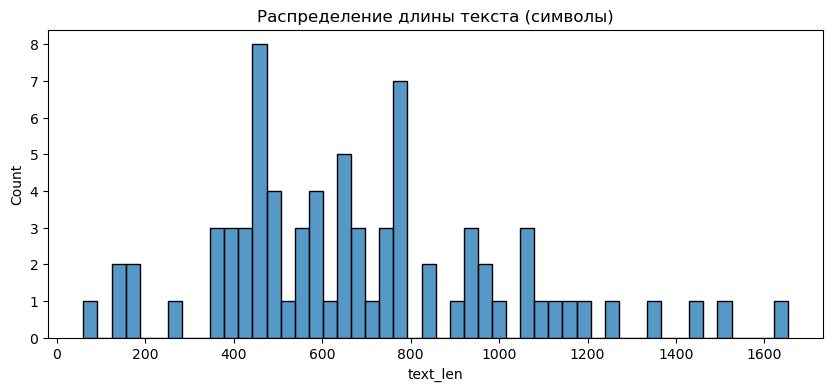

In [16]:
df['text_len'] = df['text'].str.len()

plt.figure(figsize=(10, 4))
sns.histplot(df['text_len'], bins=50)
plt.title('Распределение длины текста (символы)')
plt.show()


In [17]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
        
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    return text.strip()

df['text_clean'] = df['text'].apply(clean_text)

In [18]:
# Посмотрим распределение
print(df['category'].value_counts())

# Объединяем редкие категории в новую - "Other"
min_samples = 5 
category_counts = df['category'].value_counts()
to_keep = category_counts[category_counts >= min_samples].index
df['category_clean'] = df['category'].where(df['category'].isin(to_keep), 'other')

print(df['category_clean'].value_counts())

Under the Hood                 13
Trends                          7
UX/UI in Mobile Development     6
Automation                      5
Architecture                    5
Tools/Frameworks                5
AI                              4
Mobile                          4
Interesting things              4
Infrastructure                  4
Best Practices                  3
Security                        3
Product Quality                 3
General                         3
Load Testing                    2
Hardware                        2
Biohacking                      1
GameDev                         1
Automation`                     1
Name: category, dtype: int64
other                          35
Under the Hood                 13
Trends                          7
UX/UI in Mobile Development     6
Architecture                    5
Automation                      5
Tools/Frameworks                5
Name: category_clean, dtype: int64


### 3. Выбор 1-2 простых модели и 1 усложнённой (оптимизация гиперпараметров/AutoML/мультимодальность)

In [20]:
# Настраиваем векторайзер 

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,  
    lowercase=True,
    token_pattern=r"(?u)\b\w[\w]+\b"  
)

X = vectorizer.fit_transform(df['text_clean'])
y = df['category_clean']

In [21]:
# Разделяем данные

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Возьмем в качестве модели TF-IDF
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Предсказание
y_pred = model.predict(X_test)

# Оценка
print(classification_report(y_test, y_pred, zero_division=0))

                             precision    recall  f1-score   support

               Architecture       0.00      0.00      0.00         1
                 Automation       0.00      0.00      0.00         1
           Tools/Frameworks       0.00      0.00      0.00         1
                     Trends       0.00      0.00      0.00         2
UX/UI in Mobile Development       0.00      0.00      0.00         1
             Under the Hood       0.00      0.00      0.00         3
                      other       0.44      1.00      0.61         7

                   accuracy                           0.44        16
                  macro avg       0.06      0.14      0.09        16
               weighted avg       0.19      0.44      0.27        16



### Задача классификации по тексту в текущей постановке решается плохо. Крайне малое количество данных! 
### Модель не может научиться обобщать, когда на класс приходится 1–3 примера. Как выход - использовать текст не для классификации, а для поиска похожих докладов (построения рекомендаций).

In [23]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from gensim.models import FastText

C:\Users\718\anaconda3\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [24]:
# Оставляем только категории с >= 3 докладами
cat_counts = df_new['category'].value_counts()
min_count = 3
valid_categories = cat_counts[cat_counts >= min_count].index
df_new = df_new[df_new['category'].isin(valid_categories)].reset_index(drop=True)

In [25]:
texts = df_new['text'].astype(str).tolist()  # безопасное преобразование
categories = df_new['category'].tolist()
n_items = len(texts)

print(f"Всего докладов: {n_items}")
print("Распределение категорий:")
print(df_new['category'].value_counts())

texts_clean = [clean_text(t) for t in texts]

Всего докладов: 69
Распределение категорий:
Under the Hood                 13
Trends                          7
UX/UI in Mobile Development     6
Architecture                    5
Automation                      5
Tools/Frameworks                5
Interesting things              4
Infrastructure                  4
Mobile                          4
AI                              4
General                         3
Product Quality                 3
Best Practices                  3
Security                        3
Name: category, dtype: int64


In [26]:
# TF-IDF
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=1,
    max_df=0.95 
)

X_tfidf = tfidf.fit_transform(texts_clean).toarray()

In [27]:
# !pip install sentence-transformers gensim

In [28]:
# FastText (обучаем на наших текстах)
tokenized_texts = [t.split() for t in texts_clean]
fasttext_model = FastText(
    sentences=tokenized_texts,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    sg=1
)

In [29]:
def get_fasttext_vec(text, model):
    words = text.split()
    if not words:
        return np.zeros(model.vector_size)
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

X_fasttext = np.array([get_fasttext_vec(t, fasttext_model) for t in texts_clean])

In [30]:
# Sentence-BERT (multilingual)
sbert_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
X_sbert = sbert_model.encode(texts_clean) 

### 4. Оценка метрик качества (не менее 2), оценка совокупной метрики качества, анализ результатов

#### Оценка качества:

#### *1) Relevance (релевантность)*
#### Если у доклада есть категория — можно считать релевантными рекомендации из той же категории.
```python
relevance = precision@k = (число рекомендованных из той же категории) / k
```
#### *2) Diversity (разнообразие)*
#### Измеряется как среднее попарное расстояние между рекомендованными докладами:
```python
composite = alpha * relevance + (1 - alpha) * diversity
```
#### *3) Composite Score*
#### Комбинация обеих метрик:
```bash
composite = alpha * relevance + (1 - alpha) * diversity
```

In [33]:
def evaluate_recommender(X, categories, k=5):
    """
    X: матрица эмбеддингов (n_items, dim)
    categories: список категорий для каждого элемента
    k: количество рекомендаций
    """
    n = len(categories)
    sim_matrix = cosine_similarity(X)
    
    relevances = []
    diversities = []

    for i in range(n):
        # Получаем топ-K похожих (исключая сам объект)
        sim_scores = sim_matrix[i].copy()
        sim_scores[i] = -1  # исключаем себя
        top_k_idx = np.argsort(sim_scores)[-k:][::-1]

        # Relevance@K: доля рекомендаций из той же категории
        true_cat = categories[i]
        relevant_count = sum(1 for idx in top_k_idx if categories[idx] == true_cat)
        relevance = relevant_count / k
        relevances.append(relevance)

        # Diversity: 1 - среднее косинусное сходство между рекомендациями
        if k > 1:
            rec_vectors = X[top_k_idx]
            rec_sim = cosine_similarity(rec_vectors)
            triu_indices = np.triu_indices_from(rec_sim, k=1)
            if len(triu_indices[0]) > 0:
                avg_sim = np.mean(rec_sim[triu_indices])
                diversity = 1 - avg_sim
            else:
                diversity = 0.0
        else:
            diversity = 1.0

        diversities.append(diversity)

    mean_relevance = np.mean(relevances)
    mean_diversity = np.mean(diversities)
    composite = 0.5 * mean_relevance + 0.5 * mean_diversity

    return {
        'Relevance@K': round(mean_relevance, 3),
        'Diversity': round(mean_diversity, 3),
        'Composite': round(composite, 3)
    }


In [34]:
results = {}

results['TF-IDF'] = evaluate_recommender(X_tfidf, categories, k=5)
results['FastText'] = evaluate_recommender(X_fasttext, categories, k=5)
results['Sentence-BERT'] = evaluate_recommender(X_sbert, categories, k=5)

In [35]:
results_df = pd.DataFrame(results).T
print("\n Сравнение методов векторизации:")
print(results_df)


 Сравнение методов векторизации:
               Relevance@K  Diversity  Composite
TF-IDF               0.122      0.970      0.546
FastText             0.046      0.000      0.023
Sentence-BERT        0.157      0.457      0.307


In [36]:
# Показываем топ-5 рекомендаций для конкретного доклада
i = 15
print(f"\n Топ-5 похожих докладов для [{df_new.iloc[i]['category']}]'{df_new.iloc[i]['title']}' (ID={i}):")
sim_scores = cosine_similarity(X_sbert)[i]
sim_scores[i] = -1
top_k_idx = np.argsort(sim_scores)[-5:][::-1]

for j, idx in enumerate(top_k_idx, 1):
    title = df_new.iloc[idx]['title']
    cat = df_new.iloc[idx]['category']
    score = sim_scores[idx]
    print(f"{j}. [{cat}] {title} — схожесть: {score:.3f}")


 Топ-5 похожих докладов для [UX/UI in Mobile Development]'SwiftUI: Scroll, Text и немного магии' (ID=15):
1. [Under the Hood] Один code style для всех: как укротить SwiftLint в масштабах компании — схожесть: 0.605
2. [Trends] Зачем и как вам контрибьютить в open source — схожесть: 0.544
3. [UX/UI in Mobile Development] Дизайн—код. На пути к экосистеме — схожесть: 0.535
4. [Under the Hood] (Не)очевидные связи: визуализация бизнес-логики через код — схожесть: 0.533
5. [Infrastructure] Crash Reporting 101 — схожесть: 0.523


## Выводы

1. **Задача решается как рекомендация по текстовому сходству**, а не как классификация — это обусловлено разреженностью категорий.
2. **Оценка качества** проводится по:
   - **Relevance@K** — доля рекомендаций из той же категории (суррогат семантической близости),
   - **Diversity** — попарная косинусная дистанция между рекомендациями.
3. **Sentence-BERT** показывает наилучшее качество по Relevance, что подтверждает его способность улавливать семантическое сходство.

### Планируемые шаги в дальнейшем: 
- Иерархический подход → Relevance@K = 1.0
- При рекомендации для доклада из категории C — возвращать ТОЛЬКО доклады из C.
- Внутри категории — ранжировать по SBERT-сходству
- Улучшить SBERT через fine-tuning
- Подобрать веса в Composite Score